# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 12: Examing the transient and equilibrium CO$_2$ response in the CESM

## Warning: content out of date and not maintained

You really should be looking at [The Climate Laboratory book](https://brian-rose.github.io/ClimateLaboratoryBook) by Brian Rose, where all the same content (and more!) is kept up to date.

***Here you are likely to find broken links and broken code.***

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

## Contents

...

I have run two sets of experiments with the CESM model:

- The fully coupled model:
    - pre-industrial control
    - 1%/year CO2 ramp scenario for 80 years 
- The slab ocean model:
    - pre-industrial control with prescribed q-flux
    - 2xCO2 scenario run out to equilibrium

Our main first task is to compute the two canonical measures of climate sensitivity for this model:

- Equilibrium Climate Sensitivity (ECS)
- Transient Climate Response (TCR)

From the IPCC AR5 WG1 report, Chapter 9, page 817:

> Equilibrium climate sensitivity (ECS) is the equilibrium change in global and annual mean surface air temperature after doubling the atmos- pheric concentration of CO2 relative to pre-industrial levels. 

> The transient climate response (TCR) is the change in global and annual mean surface temperature from an experiment in which the CO2 con- centration is increased by 1% yr–1, and calculated using the difference between the start of the experiment and a 20-year period centred on the time of CO2 doubling. 

### First, a quick demonstration that 1%/year compounded increase reaches doubling after 70 years

In [1]:
startingamount = 1.
amount = startingamount
for n in range(70):
    amount *= 1.01
amount

2.006763368395386

TCR is always smaller than ECS due to the transient effects of ocean heat uptake.

We are going to **estimate** the ECS of the fully coupled model by using the equilibrium response of the Slab Ocean .

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

## Load the concatenated output from the CAM output (atmosphere)

In [3]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'

In [4]:
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


###  A plot of the prescribed CO2 concentrations in the coupled simulations

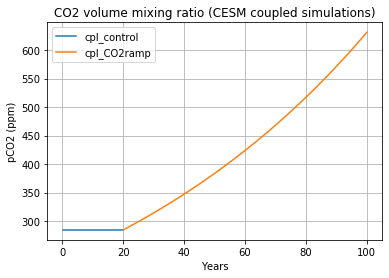

In [5]:
days_per_year = 365
fig, ax = plt.subplots()
for name in ['cpl_control', 'cpl_CO2ramp']:
    ax.plot(atm[name].time/days_per_year, atm[name].co2vmr*1E6, label=name)
ax.set_title('CO2 volume mixing ratio (CESM coupled simulations)')
ax.set_xlabel('Years')
ax.set_ylabel('pCO2 (ppm)')
ax.grid()
ax.legend();

Issues to think about:

- Why do we talk about fractional changes in CO2, such as "doubling atmospheric CO2", and "1%/year compounded CO2 increase?
- Why not instead talk about changes in absolute amounts of CO2?

The answer is closely related to the fact that the **radiative forcing** associated with CO2 increase is approximately **logarithmic** in CO2 amount. So a doubling of CO2 represents roughly the same radiative forcing *regardless of the initial CO2 concentration*.

## Compute and plot time series of global, annual mean near-surface air temperature in all four simulations

In [6]:
# The surface air temperature, which we will use for our sensitivity metrics
atm['cpl_control'].TREFHT

<xarray.DataArray 'TREFHT' (time: 240, lat: 96, lon: 144)>
[3317760 values with dtype=float32]
Coordinates:
  * time     (time) float64 31.0 59.0 90.0 120.0 ... 7.239e+03 7.269e+03 7.3e+03
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    units:         K
    long_name:     Reference height temperature
    cell_methods:  time: mean

In [7]:
#  The area weighting needed for global averaging
gw = atm['som_control'].gw
print(gw)

<xarray.DataArray 'gw' (lat: 96)>
array([0.000137, 0.001093, 0.002185, 0.003275, 0.004361, 0.005443, 0.006518,
       0.007587, 0.008647, 0.009697, 0.010737, 0.011765, 0.012781, 0.013782,
       0.014768, 0.015739, 0.016692, 0.017626, 0.018542, 0.019437, 0.020311,
       0.021162, 0.021991, 0.022795, 0.023575, 0.024329, 0.025056, 0.025756,
       0.026427, 0.02707 , 0.027683, 0.028266, 0.028818, 0.029339, 0.029827,
       0.030283, 0.030705, 0.031094, 0.031449, 0.03177 , 0.032056, 0.032307,
       0.032522, 0.032702, 0.032847, 0.032955, 0.033027, 0.033063, 0.033063,
       0.033027, 0.032955, 0.032847, 0.032702, 0.032522, 0.032307, 0.032056,
       0.03177 , 0.031449, 0.031094, 0.030705, 0.030283, 0.029827, 0.029339,
       0.028818, 0.028266, 0.027683, 0.02707 , 0.026427, 0.025756, 0.025056,
       0.024329, 0.023575, 0.022795, 0.021991, 0.021162, 0.020311, 0.019437,
       0.018542, 0.017626, 0.016692, 0.015739, 0.014768, 0.013782, 0.012781,
       0.011765, 0.010737, 0.009697, 0.008

In [8]:
def global_mean(field, weight=gw):
    '''Return the area-weighted global average of the input field'''
    return (field*weight).mean(dim=('lat','lon'))/weight.mean(dim='lat')

In [9]:
#  Loop through the four simulations and produce the global mean timeseries
TREFHT_global = {}
for name in casenames:
    TREFHT_global[name] = global_mean(atm[name].TREFHT)

#### Make some pretty timeseries plots, including an **approximate** running annual average

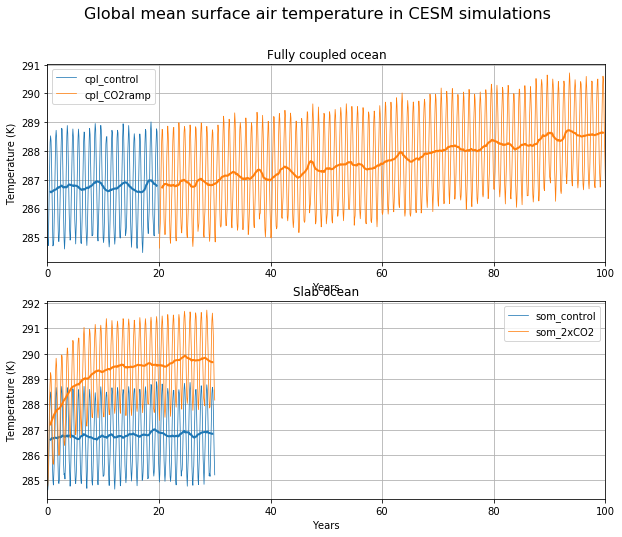

In [10]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for name in casenames:
    if 'cpl' in name:
        ax = axes[0]
        ax.set_title('Fully coupled ocean')
    else:
        ax = axes[1]
        ax.set_title('Slab ocean')
    field = TREFHT_global[name]
    field_running = field.rolling(time=12, center=True).mean()
    line = ax.plot(field.time / days_per_year, 
                   field, 
                   label=name,
                   linewidth=0.75,
                   )
    ax.plot(field_running.time / days_per_year, 
            field_running, 
            color=line[0].get_color(),
            linewidth=2,
           )
for ax in axes:
    ax.legend();
    ax.set_xlabel('Years')
    ax.set_ylabel('Temperature (K)')
    ax.grid();
    ax.set_xlim(0,100)
fig.suptitle('Global mean surface air temperature in CESM simulations', fontsize=16);

Issues to think about here include:

- Why is the annual average here only approximate? *(think about the calendar)*
- Why is there an annual cycle in the global average temperature? (planet is coldest during NH winter)
- Different character of the temperature **variability** in the coupled vs. slab model
- Much more rapid warming in the Slab Ocean Model

## Now we can work on computing ECS and TCR

In [11]:
# extract the last 10 years from the slab ocean control simulation
# and the last 20 years from the coupled control
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

In [12]:
# extract the last 10 years from the slab ocean control simulation
T0_slab = TREFHT_global['som_control'].isel(time=clim_slice_slab).mean(dim='time')
T0_slab

<xarray.DataArray ()>
array(286.824865)

In [13]:
# and the last 20 years from the coupled control
T0_cpl = TREFHT_global['cpl_control'].isel(time=clim_slice_cpl).mean(dim='time')
T0_cpl

<xarray.DataArray ()>
array(286.751259)

In [14]:
# extract the last 10 years from the slab 2xCO2 simulation
T2x_slab = TREFHT_global['som_2xCO2'].isel(time=clim_slice_slab).mean(dim='time')
T2x_slab

<xarray.DataArray ()>
array(289.715214)

In [15]:
# extract the last 20 years from the coupled CO2 ramp simulation
T2x_cpl = TREFHT_global['cpl_CO2ramp'].isel(time=clim_slice_cpl).mean(dim='time')
T2x_cpl

<xarray.DataArray ()>
array(288.419353)

In [16]:
ECS = T2x_slab - T0_slab
TCR = T2x_cpl - T0_cpl
print('The Equilibrium Climate Sensitivity is {:.3} K.'.format(float(ECS)))
print('The Transient Climate Response is {:.3} K.'.format(float(TCR)))

The Equilibrium Climate Sensitivity is 2.89 K.
The Transient Climate Response is 1.67 K.


## Some CMIP climate sensitivity results to compare against

<img src='http://www.climatechange2013.org/images/figures/WGI_AR5_Fig9-43.jpg' width=800>

<img src='../images/AR5_Table9.5.png'>

Comparing against the multi-model mean of the ECS and TCR, our model is apparently slightly less sensitive than the CMIP5 mean.

## Let's make some maps to compare spatial patterns of transient vs. equilibrium warming

Here is a helper function that takes a 2D lat/lon field and renders it as a nice contour map with accompanying zonal average line plot.

In [17]:
# The map projection capabilities come from the cartopy package. There are many possible projections
import cartopy.crs as ccrs

In [18]:
def make_map(field):
    '''input field should be a 2D xarray.DataArray on a lat/lon grid.
        Make a filled contour plot of the field, and a line plot of the zonal mean
    '''
    fig = plt.figure(figsize=(14,6))
    nrows = 10; ncols = 3
    mapax = plt.subplot2grid((nrows,ncols), (0,0), colspan=ncols-1, rowspan=nrows-1, projection=ccrs.Robinson())
    barax = plt.subplot2grid((nrows,ncols), (nrows-1,0), colspan=ncols-1)
    plotax = plt.subplot2grid((nrows,ncols), (0,ncols-1), rowspan=nrows-1)
    cx = mapax.contourf(field.lon, field.lat, field, transform=ccrs.PlateCarree())
    mapax.set_global(); mapax.coastlines();
    plt.colorbar(cx, cax=barax, orientation='horizontal')
    plotax.plot(field.mean(dim='lon'), field.lat)
    plotax.set_ylabel('Latitude')
    plotax.grid()
    return fig, (mapax, plotax, barax), cx

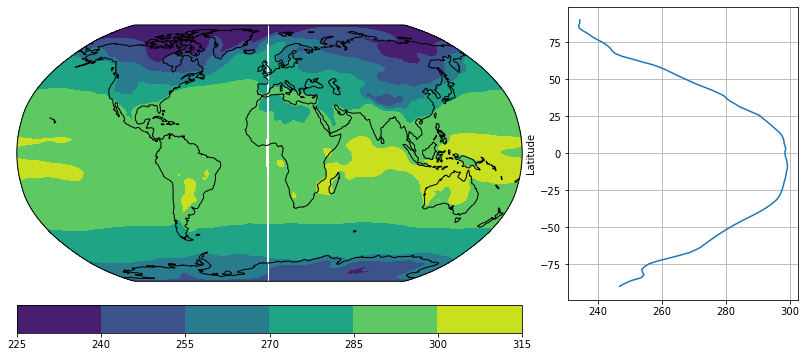

In [19]:
# Plot a single time slice of surface air temperature just as example
fig, axes, cx = make_map(atm['cpl_control'].TREFHT.isel(time=0))

### Make maps of the surface air temperature anomaly due to CO2 doubling in both the slab and coupled models

In [20]:
Tmap_cpl_2x = atm['cpl_CO2ramp'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
Tmap_cpl_control = atm['cpl_control'].TREFHT.isel(time=clim_slice_cpl).mean(dim='time')
DeltaT_cpl = Tmap_cpl_2x - Tmap_cpl_control

Tmap_som_2x = atm['som_2xCO2'].TREFHT.isel(time=clim_slice_slab).mean(dim='time')
Tmap_som_control = atm['som_control'].TREFHT.isel(time=clim_slice_slab).mean(dim='time')
DeltaT_som = Tmap_som_2x - Tmap_som_control

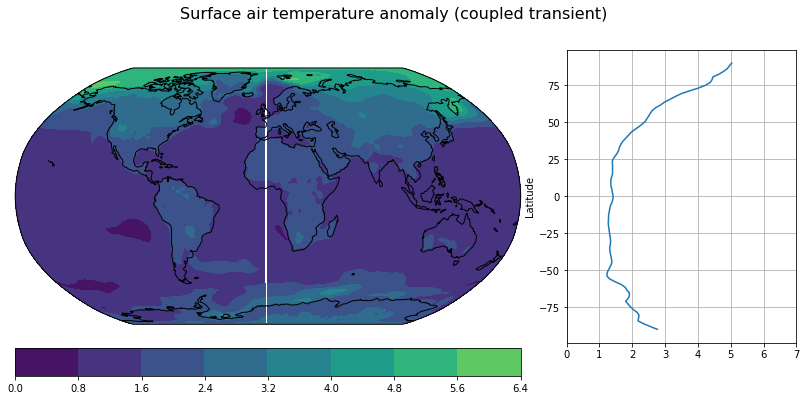

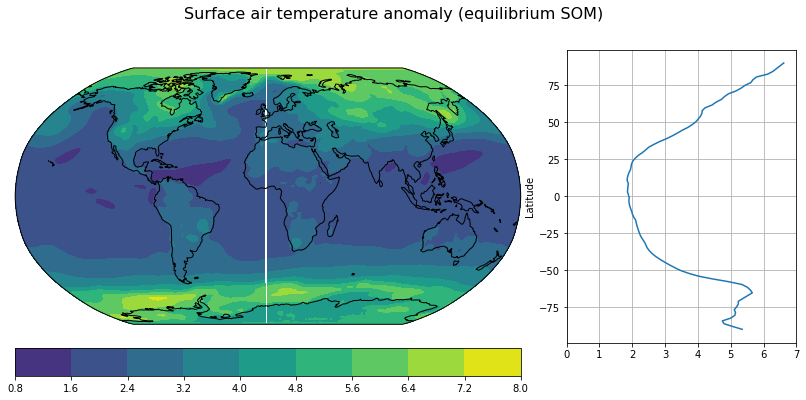

In [21]:
fig, axes, cx = make_map(DeltaT_cpl)
fig.suptitle('Surface air temperature anomaly (coupled transient)', fontsize=16);
axes[1].set_xlim(0,7)  # ensure the line plots have same axes
cx.set_clim([0, 8])    # ensure the contour maps have the same color intervals

fig, axes,cx  = make_map(DeltaT_som)
fig.suptitle('Surface air temperature anomaly (equilibrium SOM)', fontsize=16);
axes[1].set_xlim(0,7)
cx.set_clim([0, 8])

Lots of intersting phenomena to think about here, including:

- Polar amplification of surface warming
- Reduction in equator-to-pole temperature gradients
- Much larger polar amplification in SOM than in transient -- especially over the Southern Ocean (the *delayed warming of the Southern Ocean*)
- North Atlantic *warming hole* present in transient but not in equilibrium SOM.
- Land-ocean warming contrast: larger in transient, but still present in equilibrium

## Homework assignment

Continue to compare the transient and equilibrium responses in these CESM simulations.

Specifically, I would like you to examine the following:

1. Top-of-atmosphere energy budget:
    - Calculate the global mean **net TOA energy flux** for all four simulations. 
        - Which ones are close to zero in the global average, and which are not?
    - Make spatial maps of the **change in ASR** and the **change in OLR** after doubling CO2 (both transient and equilibrium).
    - Repeat for the **clear-sky** component of those changes.
    - Comment on what you found in your maps:
        - Are there any discernible spatial patterns in ASR and OLR changes?
        - What about the clear sky components? 
        - Can you relate any of these results to the surface warming maps we created above?
    
2. The hydrological cycle:
    - precipitation
    - evaporation
    - P-E
    - For each of these quantities, plot the anomalies two different ways:
        - Absolute changes
        - Normalized changes in %/K (normalized by the global mean warming)
    - Comment on which of these two perspective seems more useful, and why.
    
3. Land - ocean warming contrast:
    - Make line plots of the zonal average surface air temperature change **over land only** and **over ocean only**.

For all your results, please make an effort to point out any interesting or surprising results.

____________
## Version information
____________

In [22]:
%load_ext version_information
%version_information numpy, matplotlib, xarray, cartopy

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.7.3 64bit [Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.6.0
OS Darwin 17.7.0 x86_64 i386 64bit
numpy 1.16.4
matplotlib 3.1.1
xarray 0.12.1
cartopy 0.17.0
Wed Jul 03 14:52:57 2019 EDT

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________

## Appendix: for later reference, here is how you can open the other output types

The following will open the rest of the CESM output (land, sea ice, river routing, ocean).

These are not needed for the above homework assignment, but may be useful later on.

In [23]:
# # make a dictionary of all the CLM land model output
# land = {}
# for name in casenames:
#     path = casepaths[name] + casenames[name] + '.clm2.h0.nc'
#     print('Attempting to open the dataset ', path)
#     land[name] = xr.open_dataset(path)

In [24]:
# # make a dictionary of all the sea ice model output
# ice = {}
# for name in casenames:
#     path = casepaths[name] + casenames[name] + '.cice.h.nc'
#     print('Attempting to open the dataset ', path)
#     ice[name] = xr.open_dataset(path)

In [25]:
# # make a dictionary of all the river transport output
# rtm = {}
# for name in casenames:
#     path = casepaths[name] + casenames[name] + '.rtm.h0.nc'
#     print('Attempting to open the dataset ', path)
#     rtm[name] = xr.open_dataset(path)

In [26]:
# ocn = {}
# for name in casenames:
#     if 'cpl' in name:
#         path = casepaths[name] + casenames[name] + '.pop.h.nc'
#         print('Attempting to open the dataset ', path)
#         ocn[name] = xr.open_dataset(path)